#  CIS 545 Final Project - Amazon Reviews contd. 

![alt text](https://lh3.googleusercontent.com/G7jAks-PRl4d7IkL-s3Ir44nGyPq0Yh872N5UMwZYIJz4wG1Oj0DqoQjsAR5ddKZbQ)

This project serves as a continuation of Homework 4, where we tested a number of models on a dataset with amazon reviews and their respective ratings. In this project, we run a few different models and compare their performance in contrast to what we sae previously. The table of contents for this project are as follows

* Preprocessing
* Hyperparameter Tuning on a Random Forest Classifier
* Neural Network - PCA Data
* Neural Network - PCA Data + Time Data
* Neural Network - Only Time Data
* Linear Support Vector Machine - PCA Data
* Topic Modelling via Latent Dirichlet Analysis
* Markov model based review generation
* Graphical Pattern Analysis

# Preprocessing

![alt_text](https://www.azquotes.com/vangogh-image-quotes/2/27/Quotation-Alexander-Graham-Bell-Before-anything-else-preparation-is-the-key-to-success-2-27-39.jpg)

This section of code reuses some functions and pieces of code that were written in Homework 4 so that we can implement the relevant functions in this project. We also import a few additional libraries such as GridCV, Keras etc. 

In [1]:
%%capture
!pip install -U gensim
!pip install urllib2
!pip install markovify

In [2]:
# import stuff
import gensim
import numpy as np
import pandas as pd
import markovify
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import keras


from gensim import corpora
from gensim.models import LsiModel, KeyedVectors
from gensim.models.tfidfmodel import TfidfModel
from gensim.models.nmf import Nmf
from IPython.display import clear_output
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.svm import LinearSVC
from time import gmtime, strftime
import pprint


import sklearn.model_selection as ms
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

from datetime import *
from operator import itemgetter

Using TensorFlow backend.


In [21]:
%%capture
!wget https://cis.upenn.edu/~cis545/data/reviews.dict
!wget https://cis.upenn.edu/~cis545/data/train_reviews.mm
!wget https://cis.upenn.edu/~cis545/data/train_times.npy

In [3]:
reviews_dict = corpora.Dictionary.load("reviews.dict")
reviews_bow = corpora.MmCorpus('train_reviews.mm')
reviews_times  = np.load('train_times.npy')
print("Datasets imported")
reviews_times.shape = (len(reviews_bow),1)
y = np.vstack((np.repeat(1, 4000), np.repeat(2, 4000), np.repeat(3, 4000), np.repeat(4, 4000), np.repeat(5, 4000)))
y = np.repeat(y, 5)
print("Labels created")
normalized_model = TfidfModel(reviews_bow, normalize = True)
print("Normalized model created")
reviews_tfidf = normalized_model[reviews_bow]
print("TF-IDF Values created")

Datasets imported
Labels created
Normalized model created
TF-IDF Values created


# Hyperparameter Tuning - Random Forest Classifier

![alt_text](http://www.globalsoftwaresupport.com/wp-content/uploads/2018/02/ggff5544hh.png)

In the homework, we saw that the random forest classifier's output accuracy at most hovers around just south of 80%. Below is the piece of code that replicates what we saw. One of the fundamental assumptions was that for each tandom forest model, the value of the parameter "n_estimators" for each random forest model was set to 70. 

This means that the number of trees created in our random forest model was 70. However, how do we know whether this is the best possible option? Let's run the model we created in the HW previously and see what we observe.

In [14]:
def densify(sparse, columns):
    result = [[None for i in range(columns)] for row in range(len(sparse))]
    for i in range(0, len(sparse)):
        for j in range(0, len(sparse[i])):
            item = sparse[i][j]
            index = item[0]
            count = item[1]
            result[i][index] = count
    for i in range(0, len(result)):
        for j in range(len(result[i])):
            if result[i][j] == None:
                result[i][j] = 0
    result = np.array(result)
    return result

In [5]:
def evaluate_model(X, review_times, y):
    X = np.hstack((X, review_times))
    X_train, X_test, y_train, y_test = ms.train_test_split(X, y, test_size=0.2, random_state = 1911)
    print("split created")
    rfor = RandomForestClassifier(n_estimators=70, random_state=1911)
    print("random forest model created")
    rfor.fit(X_train, y_train)
    print("random forest model trained")
    predictions = rfor.predict(X_test)
    print("predictions obtained")
    indicators = [1 if predictions[i] == y_test[i] else 0 for i in range(0, len(y_test))]
    acc = sum(indicators)/len(indicators)
    print("accuracy calculated")
    return acc

In [6]:
def evaluate_cutoffs(X_orig, X_dict, X_times, y, cutoffs):
    results = []      
    for cutoff in cutoffs:
        print("Now calculating for " + str(cutoff))
        model = LsiModel(corpus = X_orig, num_topics = cutoff, id2word=X_dict)
        print("model trained")
        right_singular_V = [item for item in model[X_orig]]
        print("singular calculated")
        densified = densify(right_singular_V, cutoff)
        print("densified successfully")
        results.append(evaluate_model(densified, X_times, y))
        print("appended successfully")
        print(results)
        print("*********************************************************")
    return results


In [30]:
results = evaluate_cutoffs(reviews_tfidf, reviews_dict, reviews_times, y, range(10,40))

Now calculating for 10
model trained
singular calculated
densified successfully
split created
random forest model created
random forest model trained
predictions obtained
accuracy calculated
appended successfully
[0.75925]
*********************************************************
Now calculating for 11
model trained
singular calculated
densified successfully
split created
random forest model created
random forest model trained
predictions obtained
accuracy calculated
appended successfully
[0.75925, 0.7643]
*********************************************************
Now calculating for 12
model trained
singular calculated
densified successfully
split created
random forest model created
random forest model trained
predictions obtained
accuracy calculated
appended successfully
[0.75925, 0.7643, 0.77225]
*********************************************************
Now calculating for 13
model trained
singular calculated
densified successfully
split created
random forest model created
random for

In [33]:
display(results)
print("The max accuracy is: " + str(np.max(results)))
print("The index of max accuracy is: " + str(np.argmax(results)))
print("Therefore, the best cutoff is :" + str(np.argmax(results) + 10))

[0.75925,
 0.7643,
 0.77225,
 0.77725,
 0.77945,
 0.7861,
 0.7866,
 0.78615,
 0.79025,
 0.7924,
 0.79335,
 0.7941,
 0.7948,
 0.7948,
 0.79445,
 0.7955,
 0.79435,
 0.79445,
 0.795,
 0.7946,
 0.7952,
 0.7965,
 0.7964,
 0.7956,
 0.7961,
 0.79495,
 0.7963,
 0.79515,
 0.7977,
 0.7972]

The max accuracy is: 0.7977
The index of max accuracy is: 28
Therefore, the best cutoff is :38


We very clearly notice that the best accuracy is obtained at a cutoff calue of 38 (Please note that due to the random nature of this algorithm, this number might change from run-to-run). However, this figure is only valid for the case where the number of estimators (the number of trees in the random forest model) is 70. What if the accuracy was better with a greater number of trees, which is typically what happens?

Let us see how this cutoff value of 38 scales with different numbers of estimators. Therefore, we want to perform hyperparameter tuning on the random forest mode, with different values for the parameters. 

Generally, a larger number of estimators yields a higher degree of accuracy, so we want to test values between 70 and 100. Instead of manually doing so through a for loop, we use a library named GridSearchCV that allows us to input a variety of different parameters we want to test, construct models for each possible combinations of those parameters, and select the set of parameters that results in the greatest accuracy through its internal accuracy evaluation metrics. 

In this case, the only parameter we vary is n_estimators, and the following code implements this hyperparameter tuning

In [34]:
       
rfc=RandomForestClassifier(random_state=42)
possible_estimators = [i for i in range(70, 100)]
param_grid = { 
    'n_estimators': possible_estimators
}
print("parameters created")
model = LsiModel(corpus = reviews_tfidf, num_topics = 38, id2word=reviews_dict)
print("LSIMOdel made")
right_singular_V = [item for item in model[reviews_tfidf]]
print("Singular created")
densified = densify(right_singular_V, 38)
print("Densified")
X = np.hstack((densified, reviews_times))
print("X created")
X_train, X_test, y_train, y_test = ms.train_test_split(X, y, test_size=0.2, random_state = 1911)
print("Split created")
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, verbose = 10)
print("CV_rfc created")
CV_rfc.fit(X_train, y_train)
print("Now training for best params")
print(CV_rfc.best_params_)



parameters created
LSIMOdel made
Singular created
Densified
X created
Split created
CV_rfc created
Fitting 3 folds for each of 30 candidates, totalling 90 fits
[CV] n_estimators=70 .................................................


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ..................... n_estimators=70, score=0.798, total=  22.8s
[CV] n_estimators=70 .................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   22.8s remaining:    0.0s


[CV] ..................... n_estimators=70, score=0.799, total=  24.6s
[CV] n_estimators=70 .................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   47.4s remaining:    0.0s


[CV] ..................... n_estimators=70, score=0.791, total=  23.3s
[CV] n_estimators=71 .................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.2min remaining:    0.0s


[CV] ..................... n_estimators=71, score=0.798, total=  23.7s
[CV] n_estimators=71 .................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  1.6min remaining:    0.0s


[CV] ..................... n_estimators=71, score=0.799, total=  25.4s
[CV] n_estimators=71 .................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.0min remaining:    0.0s


[CV] ..................... n_estimators=71, score=0.790, total=  25.6s
[CV] n_estimators=72 .................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  2.4min remaining:    0.0s


[CV] ..................... n_estimators=72, score=0.798, total=  26.7s
[CV] n_estimators=72 .................................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  2.9min remaining:    0.0s


[CV] ..................... n_estimators=72, score=0.799, total=  23.9s
[CV] n_estimators=72 .................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  3.3min remaining:    0.0s


[CV] ..................... n_estimators=72, score=0.790, total=  25.8s
[CV] n_estimators=73 .................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  3.7min remaining:    0.0s


[CV] ..................... n_estimators=73, score=0.798, total=  25.5s
[CV] n_estimators=73 .................................................
[CV] ..................... n_estimators=73, score=0.799, total=  25.6s
[CV] n_estimators=73 .................................................
[CV] ..................... n_estimators=73, score=0.790, total=  26.3s
[CV] n_estimators=74 .................................................
[CV] ..................... n_estimators=74, score=0.798, total=  25.9s
[CV] n_estimators=74 .................................................
[CV] ..................... n_estimators=74, score=0.799, total=  25.9s
[CV] n_estimators=74 .................................................
[CV] ..................... n_estimators=74, score=0.791, total=  25.6s
[CV] n_estimators=75 .................................................
[CV] ..................... n_estimators=75, score=0.798, total=  26.5s
[CV] n_estimators=75 .................................................
[CV] .

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed: 43.1min finished


Now training for best params
{'n_estimators': 98}


Here, we can clearly notice that the best parameter value for n_estimators is 98 (Also subject to change from run to run). So we can construct a model to see how this pans out.

In [36]:
rfor = RandomForestClassifier(n_estimators=98, random_state=1911)
print("now fitting")
rfor.fit(X_train, y_train)
print("now predicting")
predictions = rfor.predict(X_test)
indicators = [1 if predictions[i] == y_test[i] else 0 for i in range(0, len(y_test))]
acc = sum(indicators)/len(indicators)
print(acc)

now fitting
now predicting
0.79635


Suprisingly, we see that the resultant accuracy for 98 estimators is slightly worse than for 70 estimators, which was our initial randomly guessed parameter (which turned out to be a pretty good guess). How does this happen? This is because gridsearch cv iterations average accuracies over 3 folds, and even though there existed an individual iteration with an accuracy of 0.801 (which is barely a small increment over our original accuracy), the average was still lower than that. Therefore, our original choice of parameters is coincidentally pretty good, and hyperparameter tuning through gridsearchcv (which takes roughly 30 minutes to fully execute) may not be required.

# Neural Networks - TF-IDF version of  BOW with 40 components

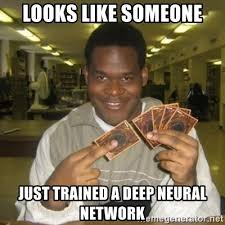

In [37]:
#Create the feature vectors through SVD
cutoff = 40
model = LsiModel(corpus = reviews_tfidf, num_topics = 40, id2word=reviews_dict)
print("Model Created")
right_singular = [item for item in model[reviews_tfidf]]
print("Singular values calculated")
X = densify(right_singular, 40)
print("Densified")

#Convert ratings to indicator arrays (Ex - rating of 2 => [0, 1, 0, 0, 0])
y_modified = []
for rating in y:
    instance = [0, 0, 0, 0, 0]
    instance[rating - 1] = 1
    y_modified.append(instance)
y_modified = np.array(y_modified)
print("y has been modified")

#Create a test train split
X_train, X_test, y_train, y_test = ms.train_test_split(X, y_modified, test_size=0.7, random_state = 1911)
print("Split has been created")

#Create a model with 3 layers (45(with input dim = 40), 20, 5)
model = Sequential()
model.add(Dense(45, input_dim=40, activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dense(5, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print("Neural network instantiated and compiled")

#Fit model
print("Fitting now")
model.fit(X_train, y_train, epochs=20, batch_size=10)
print("Fitting complete")
acc_tuple = model.evaluate(X_test, y_test)
print("Resultant loss is: " + str(acc_tuple[0]))
print("Resultant accuracy is: " + str(acc_tuple[1]))

Model Created
Singular values calculated
Densified
y has been modified
Split has been created
Neural network instantiated and compiled
Fitting now
Epoch 1/20
30000/30000 [==============================] - 4s 141us/step - loss: 0.2670 - accuracy: 0.8948
Epoch 2/20
30000/30000 [==============================] - 4s 131us/step - loss: 0.2063 - accuracy: 0.9196
Epoch 3/20
30000/30000 [==============================] - 4s 131us/step - loss: 0.2017 - accuracy: 0.9212
Epoch 4/20
30000/30000 [==============================] - 4s 139us/step - loss: 0.1988 - accuracy: 0.9225
Epoch 5/20
30000/30000 [==============================] - 4s 133us/step - loss: 0.1960 - accuracy: 0.9229
Epoch 6/20
30000/30000 [==============================] - 4s 132us/step - loss: 0.1932 - accuracy: 0.9243
Epoch 7/20
30000/30000 [==============================] - 4s 134us/step - loss: 0.1911 - accuracy: 0.9250
Epoch 8/20
30000/30000 [==============================] - 4s 131us/step - loss: 0.1888 - accuracy: 0.9259
Epoch

An accuracy of 92.8722%.......that's a pretty fat YEET if you ask me!

Now do we trust the Neural Network's internal evaluation metrics? No, because these accuracy values may be somewhat inflated. In this process of classification, we are operating in a binary context where loss should be 0 for an incorrect prediction, and 1 for a correct one, whereas the NN's evaluation metrics assigns intermedary values in the 0-1 interval since the correct neuron's activation is almost never 1, and vice versa. So let's see how accurate the predictions are by themselves.

In [41]:
result = model.predict(X_test)
counter = 0
for i in range(len(y_test)):
    pred = np.argmax(result[i], axis = 0)
    actual = np.argmax(y_test[i], axis = 0)
    if pred == actual: counter += 1
print(counter/len(X_test))

0.8106571428571429


81%.....Still a reasonably fat YEET if you asks me!

# Neural Networks Round 2 - TF-IDF version of  BOW with 40 components + Month Data

![alt_text](https://i.pinimg.com/originals/eb/ae/f4/ebaef44cca839e08eedebb2f5f80ea13.jpg)

We now try to see if adding times helps the neural network's accuracy at all. We construct a neural network similar to how we did before, but this time incorporating just the SVD decomposition with 40 components as well as time data as a feature in the form of the month in which a review was given. Maybe there are some patterns we don't notice. Do people give higher reviews during holidays? Lower reviews during winter months or recessions? Who knows - let's see what happens

In [55]:
#Here, we create a function that allows us to convert microseconds to months so that we can "normalize" it 
#to a smaller range of values
def convertMicrosecondsToMonth(microseconds):
    seconds = microseconds / 1000000
    converted_time = gmtime(seconds)
    month = strftime("%m", converted_time)
    return int(month)
months = [convertMicrosecondsToMonth(item) for item in reviews_times]
print("Months created")

#Create the feature vectors through SVD
cutoff = 40
model = LsiModel(corpus = reviews_tfidf, num_topics = 40, id2word=reviews_dict)
print("Model Created")
right_singular = [item for item in model[reviews_tfidf]]
print("Singular values calculated")
X = densify(right_singular, 40)
print("Densified")
X_new = []
for i in range(0, len(X)):
    vector = X[i]
    #This normalizes months even further by converting them to values between 0 and 1
    month = months[i]/12
    appended = np.append(vector, [month])
    X_new.append(appended)
X = np.array(X_new)
print("New feature set created")

#Convert ratings to indicator arrays (Ex - rating of 2 => [0, 1, 0, 0, 0])
y_modified = []
for rating in y:
    instance = [0, 0, 0, 0, 0]
    instance[rating - 1] = 1
    y_modified.append(instance)
y_modified = np.array(y_modified)
print("y has been modified")

#Create a test train split
X_train, X_test, y_train, y_test = ms.train_test_split(X, y_modified, test_size=0.7, random_state = 1911)
print("Split has been created")

#Create a model with 3 layers (45(with input dim = 41), 20, 5)
model = Sequential()
model.add(Dense(45, input_dim=41, activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dense(5, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print("Neural network instantiated and compiled")

#Fit model
print("Fitting now")
model.fit(X_train, y_train, epochs=20, batch_size=10)
print("Fitting complete")
acc_tuple = model.evaluate(X_test, y_test)
print("Resultant loss is: " + str(acc_tuple[0]))
print("Resultant accuracy is: " + str(acc_tuple[1]))

Months created
Model Created
Singular values calculated
Densified
New feature set created
y has been modified
Split has been created
Neural network instantiated and compiled
Fitting now
Epoch 1/20
30000/30000 [==============================] - 4s 140us/step - loss: 0.2798 - accuracy: 0.8887
Epoch 2/20
30000/30000 [==============================] - 4s 135us/step - loss: 0.2073 - accuracy: 0.9192
Epoch 3/20
30000/30000 [==============================] - 4s 132us/step - loss: 0.2008 - accuracy: 0.9218
Epoch 4/20
30000/30000 [==============================] - 4s 134us/step - loss: 0.1974 - accuracy: 0.9231
Epoch 5/20
30000/30000 [==============================] - 4s 133us/step - loss: 0.1942 - accuracy: 0.9237
Epoch 6/20
30000/30000 [==============================] - 4s 129us/step - loss: 0.1917 - accuracy: 0.9250
Epoch 7/20
30000/30000 [==============================] - 4s 145us/step - loss: 0.1896 - accuracy: 0.9256
Epoch 8/20
30000/30000 [==============================] - 4s 135us/step 

An accuracy of 92.97% instead on the 92.87% we saw previously!!!! Although this may not seem like much, on a dataset of 100000 reviews, this implies that about a 100 additional reviews are now more accurately classified!

# Neural Network Part 3 - Only Time

![alt_text](https://pics.me.me/thumb_corporate-needs-you-to-find-the-differences-between-this-picture-56774219.png)

In the previously created model, we saw that the addition of time results in a slightly better accuracy. However, the scale of the dimensionality reduced values are of the order of O(10^-2), whereas normalized months are of O(10^-1), which may mean that they're skewing some of the results in an incorrect direction. What if these time values independently encode some kind of information? Seems unlikely right? Let's throw a neural network at this once again and see how accurate we can get!

In [57]:
y_modified = []
for rating in y:
    instance = [0, 0, 0, 0, 0]
    instance[rating - 1] = 1
    y_modified.append(instance)
y_modified = np.array(y_modified)
print("Modified labels created")
X_2 = reviews_times
X_train, X_test, y_train, y_test = ms.train_test_split(X_2, y_modified, test_size=0.7, random_state = 1911)
print("Split Created")
model = Sequential()
model.add(Dense(5, input_dim=1, activation='relu'))
model.add(Dense(5, activation='relu'))
model.add(Dense(5, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])
print("Model initialized and compiled")
#Fit model
print("Fitting now")
model.fit(X_train, y_train, epochs=20, batch_size=10)
print("Fitting complete")
acc_tuple = model.evaluate(X_test, y_test)
print("Resultant loss is: " + str(acc_tuple[0]))
print("Resultant accuracy is: " + str(acc_tuple[1]))

Modified labels created
Split Created
Model initialized and compiled
Fitting now
Epoch 1/20
30000/30000 [==============================] - 3s 110us/step - loss: 36739.7132 - accuracy: 0.7998
Epoch 2/20
30000/30000 [==============================] - 3s 106us/step - loss: 0.5069 - accuracy: 0.8000
Epoch 3/20
30000/30000 [==============================] - 3s 106us/step - loss: 0.5012 - accuracy: 0.8000
Epoch 4/20
30000/30000 [==============================] - 3s 106us/step - loss: 0.5005 - accuracy: 0.8000
Epoch 5/20
30000/30000 [==============================] - 3s 104us/step - loss: 0.5004 - accuracy: 0.8000
Epoch 6/20
30000/30000 [==============================] - 3s 107us/step - loss: 0.5004 - accuracy: 0.8000
Epoch 7/20
30000/30000 [==============================] - 3s 108us/step - loss: 0.5004 - accuracy: 0.8000
Epoch 8/20
30000/30000 [==============================] - 3s 108us/step - loss: 0.5004 - accuracy: 0.8000
Epoch 9/20
30000/30000 [==============================] - 3s 108us/

Time therefore encodes some very relevant information, because we see that training a non-linear model on *only* time still allows us to create a neural network with 80% accuracy. That's pretty wild.

# Linear SVM

As a last at attempt at making and analyzing another classifier, we make a Support Vector Machine with PCA data using 60 components and see how it performs

In [8]:
model = LsiModel(corpus = reviews_tfidf, num_topics = 60, id2word=reviews_dict)
print("model made")
right_singular = [item for item in model[reviews_tfidf]]
print("singular created")
X = densify(right_singular, 60)
print("densified")
X_train, X_test, y_train, y_test = ms.train_test_split(X, y, test_size=0.7, random_state = 1911)
print("split")
clf = LinearSVC(random_state=0, multi_class = 'ovr', verbose = 10)
print("SVM created")
clf.fit(X_train, y_train)
print("SVM fitted")
print("The accuracy is " + str(clf.score(X_test, y_test)))

model made
singular created
densified
split
SVM created
[LibLinear]SVM fitted
The accuracy is 0.8071714285714285


80% Accuracy! Even though this isn't as good as the neural network which can embody more complex non-linear models, it performs very well for a purely linear classifier. 

# Topic Modelling through Latent Dirichlet Allocation

![alt_text](https://miro.medium.com/max/638/0*Sj65xR38wDwuxhtr.jpg)

In natural language processing, latent Dirichlet allocation (LDA) is a generative statistical model that allows sets of observations to be explained by unobserved groups that explain why some parts of the data are similar. For example, if observations are words collected into documents, it posits that each document is a mixture of a small number of topics and that each word's presence is attributable to one of the document's topics. LDA is an example of a topic model.

Therefore, for this entire set of amazon reviews, let us try and find what the top 10 most represented topics are (note that there may be minor variations each time this piece of code is run :D  ). This gives us a good idea about what kind of reviews are largely present in the dataset, this time in a more qualitative sense. 

In [8]:
ldamodel = gensim.models.ldamodel.LdaModel(corpus=reviews_bow, id2word = reviews_dict, num_topics = 10)

In [17]:
%pprint
pprint.pprint(ldamodel.print_topics())

Pretty printing has been turned ON
[(0,
  '0.017*"size" + 0.017*"fit" + 0.013*"like" + 0.010*"comfort" + 0.010*"wear" '
  '+ 0.009*"look" + 0.009*"just" + 0.009*"one" + 0.008*"well" + 0.008*"good"'),
 (1,
  '0.019*"product" + 0.014*"use" + 0.009*"cold" + 0.009*"wash" + 0.008*"well" '
  '+ 0.007*"will" + 0.007*"good" + 0.007*"one" + 0.006*"purchas" + '
  '0.006*"heat"'),
 (2,
  '0.042*"love" + 0.036*"great" + 0.025*"scale" + 0.017*"one" + 0.016*"like" + '
  '0.016*"price" + 0.015*"ball" + 0.015*"chocol" + 0.014*"littl" + '
  '0.013*"good"'),
 (3,
  '0.019*"batteri" + 0.014*"light" + 0.014*"use" + 0.012*"one" + 0.011*"time" '
  '+ 0.010*"work" + 0.009*"charg" + 0.008*"can" + 0.007*"will" + 0.007*"unit"'),
 (4,
  '0.045*"razor" + 0.039*"smell" + 0.032*"use" + 0.031*"scent" + 0.026*"bag" + '
  '0.015*"box" + 0.015*"clean" + 0.013*"cloth" + 0.012*"can" + 0.011*"paper"'),
 (5,
  '0.025*"use" + 0.019*"work" + 0.015*"like" + 0.015*"get" + 0.014*"tri" + '
  '0.014*"just" + 0.014*"take" + 0.012*

# Markov-based Review Generation 

WARNING: Due to the unstructured nature of the text, the last cell in this seciton take *VERY* long to run. Please run at your own discretion.  

![alt_text](https://i.stack.imgur.com/rx8kj.png)

Markovify is a simple, extensible Markov chain generator, which when given a text seed, generates a random output based on a Markov model. 

The following piece of code is just a fun experiment, and tries to generate a bag of words of a random review when given a seed of 40000 reviews. 

In [4]:
def lookup_docs(corpus, indices):
    counter = 0
    indices = list(set(indices))
    result = []
    for doc in corpus:
        if counter in indices:
            result.append(doc)
        counter += 1
    return result

indices = [10,18]
big_indices = [i for i in range(40000)]
print("Indices Initialized")
docs = lookup_docs(reviews_bow, big_indices)
print("Docs created")


Indices Initialized
Docs created


In [5]:
def translate_review(review, reviews_dict):
    my_review = ""
    for word in review:
        index = word[0]
        frequency = int(word[1])
        my_review = my_review + ' '.join([reviews_dict[index][:]] * frequency) + ' '
    my_review.strip()
    return my_review

big_compilation = ""
counter = 0
for doc in docs:
    big_compilation = big_compilation + translate_review(doc, reviews_dict) + "."
print("Compilation created")


Compilation created


In [13]:
print("Started")
text_model = markovify.Text(big_compilation, well_formed = False)
print("Model formed, now creating instance")
instance = None
counter = 0
while instance == None:
    if counter >= 1: print("Unsuccessful")
    print("Trying again")
    instance = text_model.make_sentence(tries = 100, max_overlap_ratio = 0.9, max_overlap_total = 100)
    print("Try finished")
    counter += 1
print(instance)

Started
Model formed, now creating instance
Trying again
Try finished
abl aggress chewer disappoint good great littl littl medium seam seam think think think will day day dog one chew bed puppi feel mayb love treat seem fact anoth hunt china includ noth person difficult weight ago sit mobil babi listen music tune tune tune tune eleph eleph cozi elmer .open roll clean clean filter next put left one one one one one broke broke first get month month last last like like like like howev best caus easi finger hold share fall stay rate pass point enjoy timer compact compact toss shake level especi especi wish fun standard floor floor skid skid everywher giant giant tape cord peac leash leash leash leash leash 24lb .away just open will sound sound sound sound use use realli keep keep almost fit fit huge enjoy mistak wish origin origin chines compar wood wood wood seat obviou copi repeat shade direct desert desert written speck shell grind trail hey sucker processor walnut walnut .also better m

Well, well, that's one long boi. There could be multiple reasons for this. 
1. Bag of words structure implies little punctuation implies low density of fullstops implies long reviews
2. Bag of words structure implies no semantic ordering implies no set "rules" or word forms pertaining to how reviews should end implies long reviews

# Patterns

![alt_text](https://www.fusioncharts.com/blog/wp-content/uploads/2018/05/seaborn-python-data-visualization-libraries-fusioncharts.png)

Now that we have performed as much analysis as we could have using models, let us try to visualize some of the data. 

In [10]:
def convert_times(reviews_times):
    my_list = []
    for item in reviews_times:
        my_list.append(datetime.fromtimestamp(item[0]))
    return pd.Series(my_list)

The first thing that we notice is that the distribution of ratings should be uniform, which means that each given rating should have values 20000 instances. We can verify the integrity of the data with the bar chart presented below

(array([20000., 20000., 20000., 20000., 20000.]),
 array([1, 2, 3, 4, 5, 6]),
 <a list of 5 Patch objects>)

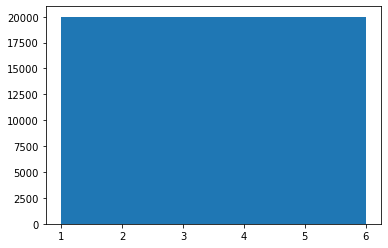

In [10]:
bins = [i for i in range(1, 7)]
plt.hist(y, bins = bins)

Now we have at our disposal the review timings and their associated ratings. First, let us see how the reviews are distributed across each distinct year. 

(array([3.0000e+00, 2.5000e+01, 5.7000e+01, 1.4200e+02, 2.9900e+02,
        2.1700e+02, 4.0900e+02, 8.6800e+02, 1.5730e+03, 3.4290e+03,
        7.9270e+03, 1.5531e+04, 4.1750e+04, 2.7770e+04]),
 array([2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011,
        2012, 2013, 2014, 2015]),
 <a list of 14 Patch objects>)

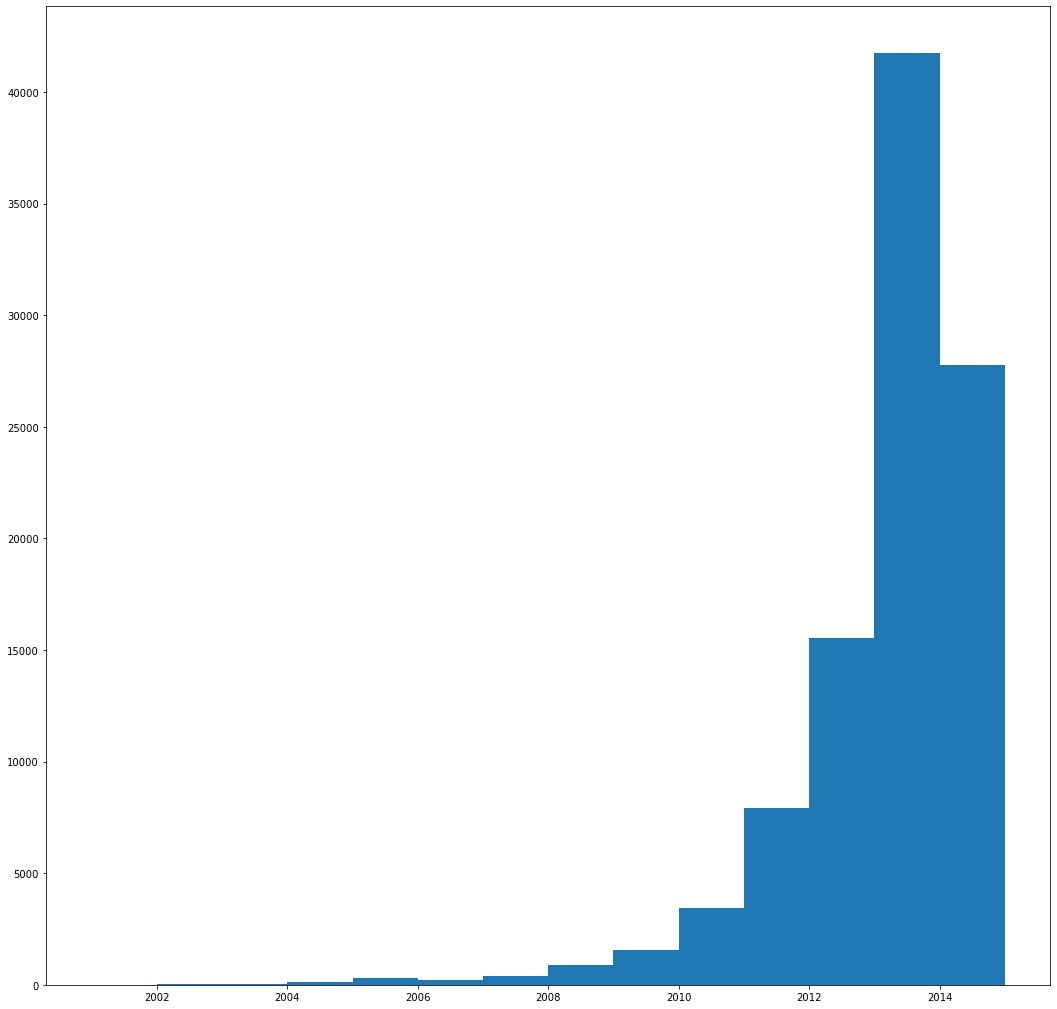

In [20]:
fig= plt.figure(figsize=(18, 18))
converted = convert_times(reviews_times)
years = [int(item.year) for item in convert_times(reviews_times)]
plt.hist(years, bins = [i for i in range(min(years), max(years) + 2)])

An interesting observation! Clearly, we can see that this distribution is skewed towards the right, which means that most of the reviews are from later years between 2012 and 2015, with the earliest dating back all the way up to 2001

Now that we have this data, let's see how the ratings might be affected by any given month. 

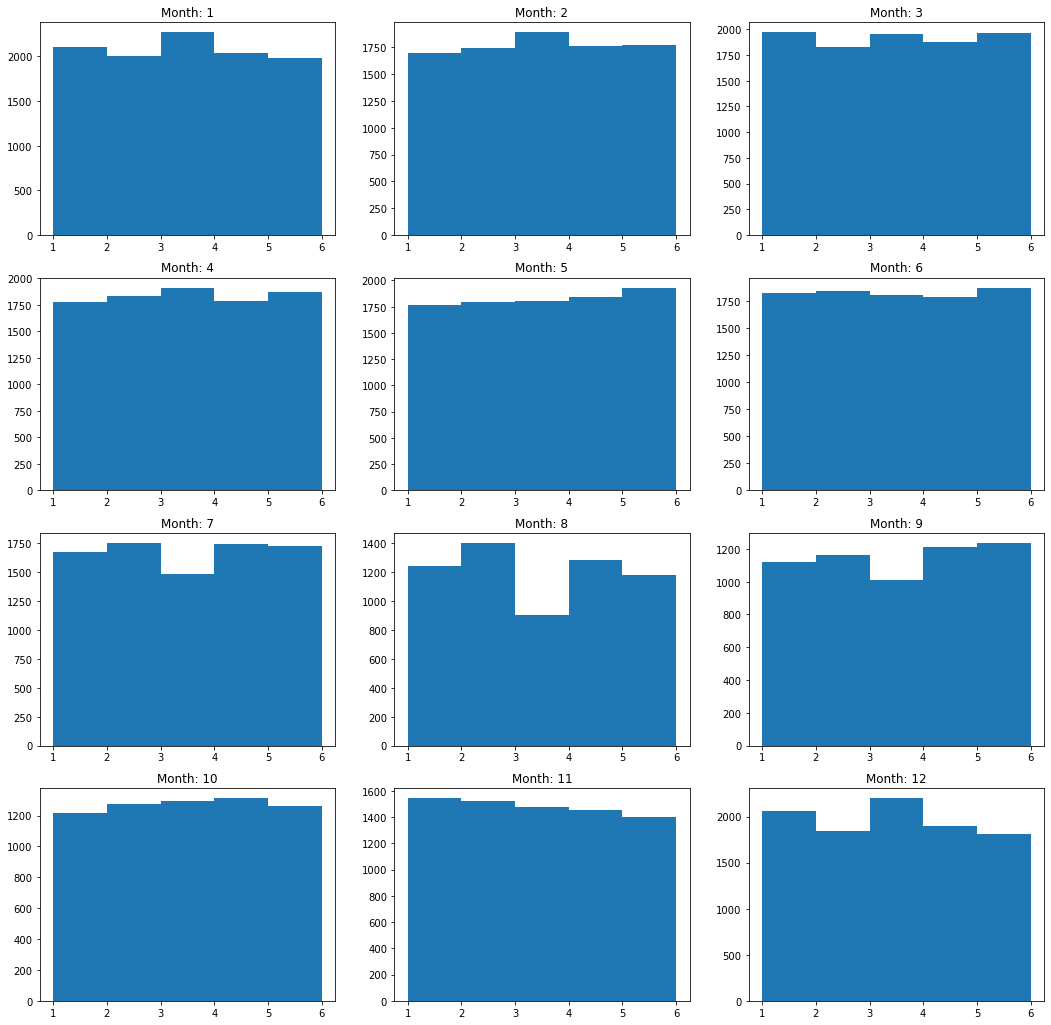

In [11]:
fig= plt.figure(figsize=(18, 18))
for j in range(1, 13):
    plt.subplot(4, 3, j)
    relevant_ratings = []
    converted = convert_times(reviews_times)
    for i in range(len(y)):
        month = int(converted[i].month)
        if month == j: relevant_ratings.append(y[i])
    bins = [i for i in range(1, 7)]
    plt.title("Month: " + str(j))
    plt.hist(relevant_ratings, bins = bins)


Through this, we see a very uniform distribution of ratings across each month, except during the summer months of July, August and September, where there is a dip in the "3" ratings. This may be because many items of utility such as ACs, cooling equipment etc are bought over and negativity/positivity bias comes into play since it's difficult to get by without these items. Therefore, if you find the product to be "okay-ish" then you wouldn't really be prompted to write a review. However, if the AC is super-good or super-defective, you might be inclined to let other people know. 

So far, we've been able to see a pattern of uniformity, but nothing about the distribution of the reviews has truly stood out. Could the information be hidden in the distributions of ratings across the different years that are represented in the datset? Let's find out. 

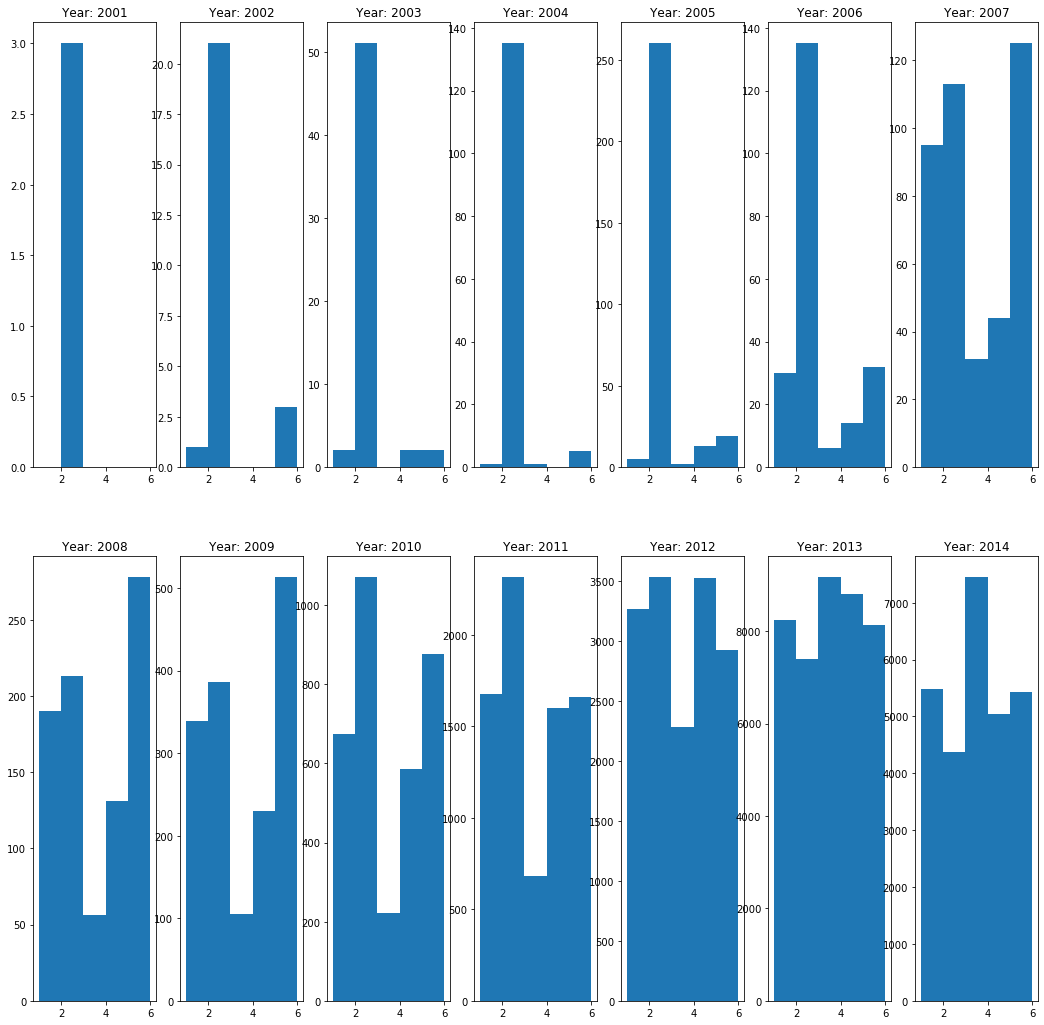

In [13]:
fig= plt.figure(figsize=(18, 18))
for j in range(2001, 2015):
    plt.subplot(2, 7, j-2000)
    relevant_ratings = []
    converted = convert_times(reviews_times)
    for i in range(len(y)):
        year = int(converted[i].year)
        if year == j: relevant_ratings.append(y[i])
    bins = [i for i in range(1, 7)]
    plt.title("Year: " + str(j))
    plt.hist(relevant_ratings, bins = bins)

Ahhhh here we go. We see that the early years between 2001 and 2006 represent generally poor reviews, whereas the later years between 2008 and 2010 represent a much stronger present of very positive reviews. Year 2012 is equally dominated by both good and bad, where as there is a huge spike in average reviews in the year 2014

# Summary

![alt_text](http://m.quickmeme.com/img/82/8231b779b92e1d5303b2ba91f6f6b3c7b2fc8fcd26dfa823ef5734c2ce3ddd5f.jpg)

Hopefully, this gives us a much better insight into the Amazon dataset. We performed hyperparameter tuning on a random forest classifier, only to find that our initial assumption was a pretty darn good one. Then we created a number of different classification models, with the neural network emerging as a winner. This wasn't too much of a surprise because the neural network can engender highly complex non-linear models. Lastly, we ended up playing with the data by seeing the most highly represented topics, generating a random review and analyzing and visualizing the patterns in the data. This project was super interesting, and hopefully you give me a good grade on this :)